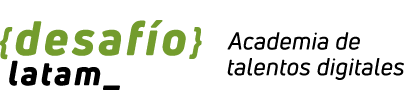

# <center><font color = 'green'>Guia de estudio - Modelos de ensamble (parte III)</font></center>

## Penalización con norma Ridge

Cargamos las librerías y los datos necesarios

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv('abalone.csv')
print(df.shape)
df.head()



(4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


La base de datos no presenta datos ausentes

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


La variable Sex es una variable nominal, que convertiremos en dummies:


In [3]:
df = pd.get_dummies(data=df, columns=['Sex'], drop_first=True, dtype=int)
df.head()


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,0


Revisaremos las correlaciones existentes entre las variables continuas:


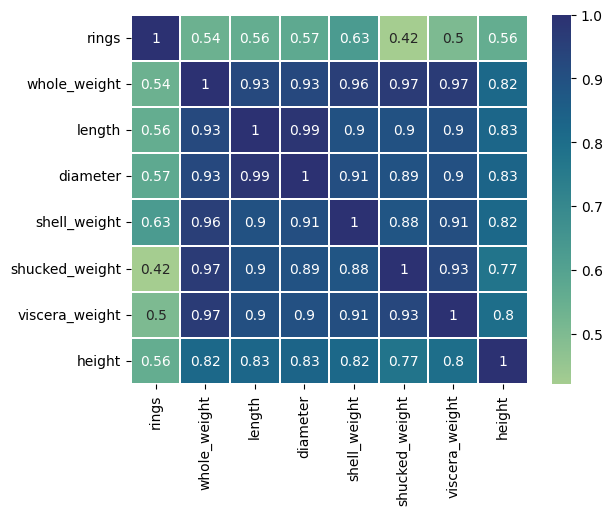

In [4]:
df.columns = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings', 'sex_i', 'sex_m']
continuous_var = list(set(df.columns) - set(['sex_i', 'sex_m']))

sns.heatmap(df[continuous_var].corr(), annot=True, linecolor='white', linewidths=0.25, cmap='crest');


Vemos altas correlaciones, ya que muchas de las variables tienen que ver con el peso de los componentes del abalone y otro grupo que está asociado a las dimensiones. Analizando las correlaciones con la variable objetivo, la correlación más alta (0.57) corresponde al diámetro, seguido por altura y el largo.

Debido a que los métodos de regularización son afectados cuando las variables regresoras están en diferentes escalas, es preciso normalizar los atributos.


In [5]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
df_std.head()


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_i,sex_m
0,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,1.571544,-0.688018,1.316677
1,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,-0.910013,-0.688018,1.316677
2,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,-0.289624,-0.688018,-0.759488
3,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,0.020571,-0.688018,1.316677
4,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,-0.910013,1.453451,-0.759488


Con el objetivo de analizar la normalidad del vector objetivo se gráfica su histograma y un qq-plot. Además, se somete a los test de Jarque-Bera y Kolmogorov-Smirnov para normalidad.

SignificanceResult(statistic=1805.465381309567, pvalue=0.0)
KstestResult(statistic=0.9981712894234812, pvalue=0.0, statistic_location=3, statistic_sign=-1)


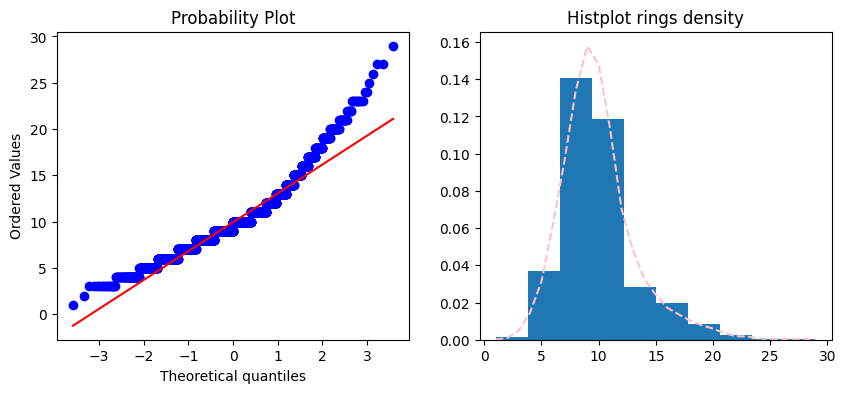

In [6]:
model_kde = sc.stats.gaussian_kde(df['rings'])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

print(sc.stats.jarque_bera(df['rings']))
print(sc.stats.kstest(df['rings'], sc.stats.norm.cdf))

sc.stats.probplot(df['rings'], dist='norm', plot=ax[0])
ax[1].hist(df['rings'], density=True)
ax[1].plot(df['rings'].sort_values(), model_kde(df['rings'].sort_values()), color='pink', ls='--')
ax[1].set_title('Histplot rings density');


En el gráfico anterior vemos como las colas se alejan de la normalidad. Por otro lado, ambos test sugieren que los datos no se distribuyen en forma normal.

Para acercar la variable objetivo a una distribución normal, transformamos la variable con el logaritmo.


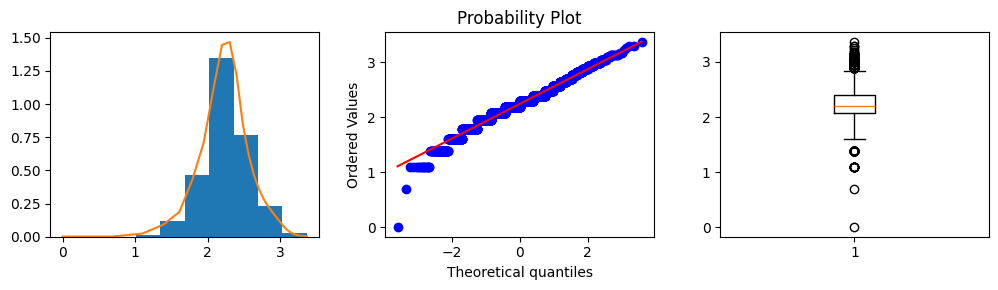

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
model_kde = sc.stats.gaussian_kde(np.log(df['rings']))
ax[0].hist(np.log(df['rings']), density=True)
ax[0].plot(np.log(df['rings'].sort_values()), model_kde(np.log(df['rings'].sort_values())))
sc.stats.probplot(np.log(df['rings']), plot=ax[1])
ax[2].boxplot(np.log(df['rings']))
plt.tight_layout()


Podemos observar que, con esto, mejora bastante la normalidad de la variable rings.

Dividimos ahora el conjunto de datos en entrenamiento y test (33%).


In [8]:
X_ss = df_std.drop(columns='rings', axis=1)
y_log = np.log(df['rings'])

X_train, X_test, y_train, y_test = train_test_split(X_ss, y_log, test_size=.33, random_state=23)


## Regularización Ridge

Entrenaremos diferentes modelos Ridge con 50 valores distintos para el parámetro lambda que en sklearn Ridge se llama alpha. Los valores que se probarán van desde 10^0 hasta 10^7. Para cada modelo se aplica validación cruzada sobre el conjunto de entrenamiento con 10 fold, y se van almacenando los coeficientes y MSE promedios.

In [9]:
# alpha
# from base**start to base**stop
lambdas = np.logspace(start=0, stop=7, base=10, num=50)

# Creamos un modelo Ridge
m_ridge = Ridge()

coefs_ridge = []
cv_err_ridge = []
cv_err_ridge_sd = [] # error estándar
fold = 10

kf = KFold(n_splits=fold)

for alpha in lambdas:
    m_ridge.set_params(alpha=alpha, fit_intercept=True)
    m_ridge.fit(X_train, y_train)
    coefs_ridge.append(m_ridge.coef_)

    cv_err_estimate = []
    for idx_train, idx_test in kf.split(X_train):
        X_train_cv = X_train.iloc[idx_train,:]
        y_train_cv = y_train.iloc[idx_train]

        X_test_cv = X_train.iloc[idx_test,:]
        y_test_cv = y_train.iloc[idx_test]
        #m_ridge.set_params(fit_intercept=True)
        m_ridge.fit(X_train_cv, y_train_cv)

        yhat_cv = m_ridge.predict(X_test_cv)
        mse = mean_squared_error(y_test_cv, yhat_cv)
        cv_err_estimate.append(mse)
    cv_err_ridge.append(np.mean(cv_err_estimate))
    cv_err_ridge_sd.append(np.std(cv_err_estimate))


In [11]:
lambdas

array([1.00000000e+00, 1.38949549e+00, 1.93069773e+00, 2.68269580e+00,
       3.72759372e+00, 5.17947468e+00, 7.19685673e+00, 1.00000000e+01,
       1.38949549e+01, 1.93069773e+01, 2.68269580e+01, 3.72759372e+01,
       5.17947468e+01, 7.19685673e+01, 1.00000000e+02, 1.38949549e+02,
       1.93069773e+02, 2.68269580e+02, 3.72759372e+02, 5.17947468e+02,
       7.19685673e+02, 1.00000000e+03, 1.38949549e+03, 1.93069773e+03,
       2.68269580e+03, 3.72759372e+03, 5.17947468e+03, 7.19685673e+03,
       1.00000000e+04, 1.38949549e+04, 1.93069773e+04, 2.68269580e+04,
       3.72759372e+04, 5.17947468e+04, 7.19685673e+04, 1.00000000e+05,
       1.38949549e+05, 1.93069773e+05, 2.68269580e+05, 3.72759372e+05,
       5.17947468e+05, 7.19685673e+05, 1.00000000e+06, 1.38949549e+06,
       1.93069773e+06, 2.68269580e+06, 3.72759372e+06, 5.17947468e+06,
       7.19685673e+06, 1.00000000e+07])

In [12]:
coefs_ridge

[array([ 0.0688162 ,  0.12396917,  0.09114062,  0.28367393, -0.36250853,
        -0.08948503,  0.07096196, -0.04312587,  0.00154001]),
 array([ 0.06884978,  0.12374469,  0.09117111,  0.27788162, -0.35966733,
        -0.08815091,  0.07289639, -0.04315754,  0.00152411]),
 array([ 0.06889895,  0.12343531,  0.09121326,  0.27018087, -0.35587202,
        -0.0863805 ,  0.07545793, -0.04320027,  0.00150259]),
 array([ 0.06897125,  0.12301054,  0.09127139,  0.26010157, -0.35087105,
        -0.0840692 ,  0.07879161, -0.04325731,  0.00147371]),
 array([ 0.0690773 ,  0.12243068,  0.0913512 ,  0.24717573, -0.34439663,
        -0.08111579,  0.0830318 , -0.0433325 ,  0.0014354 ]),
 array([ 0.06923115,  0.12164573,  0.09145999,  0.23102751, -0.33619831,
        -0.0774446 ,  0.08826593, -0.04342996,  0.00138527]),
 array([ 0.06944897,  0.12059591,  0.09160667,  0.21150216, -0.32609236,
        -0.07303671,  0.09448312, -0.0435538 ,  0.00132079]),
 array([ 0.0697448 ,  0.11921493,  0.09180105,  0.18880

Graficamos los coeficientes estimados por la validación cruzada para cada modelo correspondiente al valor alpha.

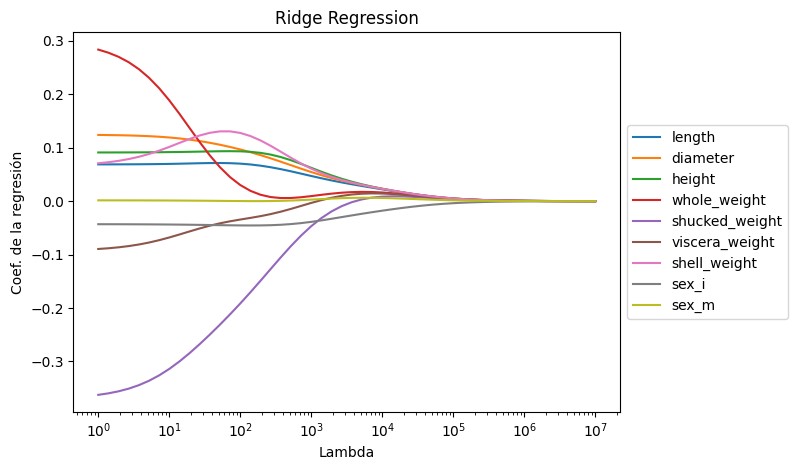

In [13]:
for y_arr, label in zip(np.array(coefs_ridge).T, X_ss.columns):
    plt.plot(lambdas, y_arr, label=label)

plt.xscale('log')
plt.legend()
plt.title('Ridge Regression')
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, .5));


Vemos que a medida que usamos una penalización mayor, los coeficientes de los parámetros se contraen acercándose a cero. Por esto, a esta norma L2 se le conoce como un regularizador que contrae (shrinkage). Se destaca que las variables de peso descascarillado y el peso total comienza con valores en sus coeficientes altos. La penalización aplicada con Ridge no permite la selección, ya que no logra impulsar a los coeficientes a cero.


Analizaremos ahora el error cuadrático promedio en raíz cuadrada para los diferentes valores de alpha (lambda)


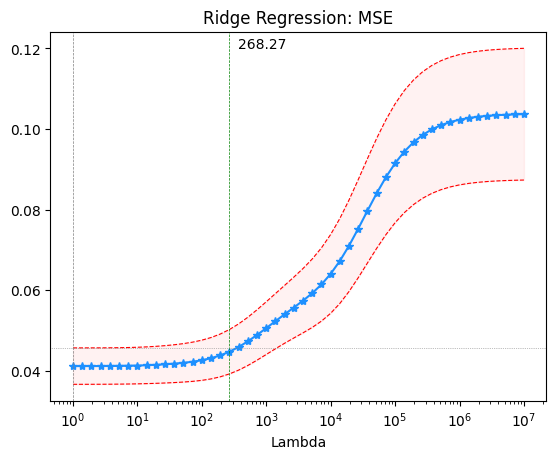

In [14]:
cv_err_ridge = np.array(cv_err_ridge)
cv_err_ridge_sd = np.array(cv_err_ridge_sd)

plt.plot(lambdas, cv_err_ridge, '*-', color='dodgerblue')
plt.plot(lambdas, cv_err_ridge+cv_err_ridge_sd, '--', color='red', lw=0.8)
plt.plot(lambdas, cv_err_ridge-cv_err_ridge_sd, '--', color='red', lw=0.8)
plt.fill_between(lambdas, cv_err_ridge-cv_err_ridge_sd, cv_err_ridge+cv_err_ridge_sd, alpha=0.05, color='red')

best_idx_ridge = np.argmin(cv_err_ridge)
best_lambda = lambdas[best_idx_ridge]
plt.axvline(x=best_lambda, color='grey', ls='--', lw=0.5)

cv_best = cv_err_ridge[best_idx_ridge]
cv_best_se = cv_err_ridge_sd[best_idx_ridge]

best_idx_ridge_1se = np.argmax(cv_err_ridge[cv_err_ridge < (cv_best + cv_best_se)])

plt.axvline(x=lambdas[best_idx_ridge_1se], color='green', ls='--', lw=0.5)
plt.text(lambdas[best_idx_ridge_1se]+100, 0.12, round(lambdas[best_idx_ridge_1se], 2))

plt.axhline(y=cv_err_ridge[best_idx_ridge] + cv_err_ridge_sd[best_idx_ridge], color='grey', lw=0.5, ls=':')

plt.xscale('log')
plt.title('Ridge Regression: MSE')
plt.xlabel('Lambda');


El mejor lambda (con el cual obtenemos el menor MSE) corresponde a. 1.0. Una metodología distinta para seleccionar al mejor lambda corresponde a encontrar el mayor lambda resultante en la validación cruzada de todos aquellos que sean menores al menor lambda en validación cruzada más su error estándar. De esta forma estaremos escogiendo el modelo más parsimonioso, con un error que no sobrepasa un error estándar de aquel con el menor error. Esto es propuesto por Hastie, T., Tibshirani, R. and Friedman, J. (2009), The Elements of Statistical Learning.

$${\widehat{\lambda}}_{CV-SE}=max\left\{\lambda:CV\left(\lambda\right)<CV\left(\widehat{\lambda}_{CV}\right)+SE\left(\widehat{\lambda}_{CV}\right)\right\}
$$

Usando este criterio nos quedamos con lambda 268.27, lo que hace obtener un MSE de 0.0456.

En esta búsqueda del  mejor alpha (lambda), sklearn nos ofrece el modelo Ridge que incorpora la validación cruzada, conocido como RidgeCV. Usando este método para el conjunto de alpha que hemos probado anteriormente obtenemos que el mejor alpha es 1.0.



In [ ]:
ridge_cv = RidgeCV(fit_intercept=True, cv=10, alphas=lambdas)
ridge_cv.fit(X_train, y_train)

# mejor alpha
print(ridge_cv.alpha_)
yhat_ridge_cv_test = ridge_cv.predict(X_test)
r2 = r2_score(y_test, yhat_ridge_cv_test)
rmse = mean_squared_error(y_test, yhat_ridge_cv_test, squared=False)
print(f'r2: {r2}')
print(f'RMSE: {rmse}')
print()

ridge_cv.coef_


## Regularización Lasso L1

Importamos las librerías necesarias

In [ ]:
from sklearn.linear_model import Lasso, LassoCV

Se entrena un modelo de regresión lineal con penalización Lasso para diferentes valores de hiper parámetro lambda entre $10^{-3}$ y $10^0$, con 100 valores.

In [ ]:
# alpha
# from base**start to base**stop
lambdas = np.logspace(start=-3, stop=0, base=10, num=100)

# Creamos un modelo Lasso
m_lasso = Lasso()

coefs_lasso = []
cv_err_lasso = []
cv_err_lasso_sd = []
fold = 10

kf = KFold(n_splits=fold)

for alpha in lambdas:
    m_lasso.set_params(alpha=alpha, fit_intercept=True)
    m_lasso.fit(X_train, y_train)
    coefs_lasso.append(m_lasso.coef_)

    cv_err_estimate = []
    for idx_train, idx_test in kf.split(X_train):
        X_train_cv = X_train.iloc[idx_train,:]
        y_train_cv = y_train.iloc[idx_train]

        X_test_cv = X_train.iloc[idx_test,:]
        y_test_cv = y_train.iloc[idx_test]

        m_lasso.fit(X_train_cv, y_train_cv)

        yhat_cv = m_lasso.predict(X_test_cv)
        mse = mean_squared_error(y_test_cv, yhat_cv)
        cv_err_estimate.append(mse)
    cv_err_lasso.append(np.mean(cv_err_estimate))
    cv_err_lasso_sd.append(np.std(cv_err_estimate,ddof=1))


Mostramos gráficamente los coeficientes estimados para cada modelo entrenado, para los diferentes valores de lambda.

In [ ]:
for y_arr, label in zip(np.array(coefs_lasso).T, X_ss.columns):
    plt.plot(lambdas, y_arr, label=label)

plt.xscale('log')
plt.legend()
plt.title('Lasso Regression')
plt.xlabel('Lambda')
plt.ylabel('Coef. de la regresión')
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, .5));


Se observa como los coeficientes rápidamente se hacen cero, (observa viscera_weight, whole_weight y lenght). Para poder estimar un valor óptimo para lambda graficaremos la curva del conjunto de valores que estamos usando y calcularemos el mejor, es decir, aquel que considere un MSE no mayor al menor de este para algún lambda más un error estándar. Seguimos así  la misma estrategía descrita en Ridge.

In [ ]:
cv_err_lasso = np.array(cv_err_lasso)
cv_err_lasso_sd = np.array(cv_err_lasso_sd)

plt.plot(lambdas, cv_err_lasso, '*-', color='dodgerblue')
plt.plot(lambdas, cv_err_lasso+cv_err_lasso_sd, '--', color='red', lw=0.8)
plt.plot(lambdas, cv_err_lasso-cv_err_lasso_sd, '--', color='red', lw=0.8)
plt.fill_between(lambdas, cv_err_lasso-cv_err_lasso_sd, cv_err_lasso+cv_err_lasso_sd, alpha=0.05, color='red')

best_idx_lasso = np.argmin(cv_err_lasso)
best_lambda = lambdas[best_idx_lasso]
plt.axvline(x=best_lambda, color='grey', ls='--', lw=0.5)

cv_best = cv_err_lasso[best_idx_lasso]
cv_best_se = cv_err_lasso_sd[best_idx_lasso]

best_idx_lasso_1se = np.argmax(cv_err_lasso[cv_err_lasso < (cv_best + cv_best_se)])

plt.axvline(x=lambdas[best_idx_lasso_1se], color='green', ls='--', lw=0.5)
plt.text(lambdas[best_idx_lasso_1se]+0.002, 0.12, round(lambdas[best_idx_lasso_1se], 2))

plt.axhline(y=cv_err_lasso[best_idx_lasso] + cv_err_lasso_sd[best_idx_lasso], color='grey', lw=0.5, ls=':')
print(cv_err_lasso[best_idx_lasso] + cv_err_lasso_sd[best_idx_lasso])

plt.xscale('log')
plt.title('Lasso Regression: MSE')
plt.xlabel('Lambda');


Obtenenemos 0.01 como mejor lambda, con el cual se descartan tres atributos: viscera_weight, whole_weight y length.

La librería sklearn tiene implementada la regresión lineal Lasso con validación cruzada LassoCV. Usando esta librería, el mejor lambda encontrado corresponde a 1e-05. Debemos considerar que este mejor alpha corresponde a un valor en que se produzca convergencia, o que se encuentre en un mínimo local.

In [ ]:
lasso_cv = LassoCV(fit_intercept=True, cv=10, alphas=lambdas)
lasso_cv.fit(X_train, y_train)

# mejor alpha
print(f'Mejor alpha (lambda): {lasso_cv.alpha_}')
yhat_lasso_cv_test = lasso_cv.predict(X_test)
r2 = r2_score(y_test, yhat_lasso_cv_test)
rmse = mean_squared_error(y_test, yhat_lasso_cv_test, squared=False)
print(f'r2: {r2}')
print(f'RMSE: {rmse}')
print()

print('Coeficientes para el mejor alpha (lambda)')
lasso_cv.coef_


Hasta aquí hemos visto cómo Ridge hace una contracción suave de los coeficientes, en comparación con Lasso que tiene la capacidad de llevar los coeficientes a cero permitiendo la selección de atributos. El último método de regularización que se revisará corresponde a una mezcla entre Ridge y Lasso, en que se busca tomar lo mejor de cada uno de ellos.

## Regularización Elastic Net



In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV #importamos las librerías necesarias

Para este ejemplo guiado usaremos l1_ratio con valor 0.5 y haremos variar alpha, lo cual significa que usará la misma proporción de regularización Ridge que de Lasso controlada para cada valor diferente alpha.

In [ ]:
# alpha
# from base**start to base**stop
lambdas = np.logspace(start=-5, stop=0, base=10, num=100)

# Creamos un modelo Lasso
m_enet = ElasticNet()

coefs_enet = []
cv_err_enet = []
cv_err_enet_sd = [] # error estándar
fold = 10

kf = KFold(n_splits=fold)

for alpha in lambdas:
    m_enet.set_params(alpha=alpha, fit_intercept=True, l1_ratio=.5)
    m_enet.fit(X_train, y_train)
    coefs_enet.append(m_enet.coef_)

    cv_err_estimate = []
    for idx_train, idx_test in kf.split(X_train):
        X_train_cv = X_train.iloc[idx_train,:]
        y_train_cv = y_train.iloc[idx_train]

        X_test_cv = X_train.iloc[idx_test,:]
        y_test_cv = y_train.iloc[idx_test]

        m_enet.fit(X_train_cv, y_train_cv)

        yhat_cv = m_enet.predict(X_test_cv)
        mse = mean_squared_error(y_test_cv, yhat_cv)
        cv_err_estimate.append(mse)
    cv_err_enet.append(np.mean(cv_err_estimate))
    cv_err_enet_sd.append(np.std(cv_err_estimate))


Visualizaremos ahora los coeficientes estimados para cada alpha, considerando lambda1 = lambda2 = alpha.

In [ ]:
for y_arr, label in zip(np.array(coefs_enet).T, X_ss.columns):
    plt.plot(lambdas, y_arr, label=label)

plt.xscale('log')
plt.legend()
plt.title('Elastic Net Regression')
plt.xlabel('Lambda1 = Lambda2')
plt.ylabel('Coef. de la regresión')
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, .5));


Al comparar este gráfico con los obtenidos sólo Ridge o Lasso vemos que con Elastic Net se logra tener la característica de Lasso para la selección de características, y también vemos que la contracción de los coeficientes se realiza en forma más suave gracias a lo que aporta Ridge.

In [ ]:
enet_cv = ElasticNetCV(fit_intercept=True, cv=10, alphas=lambdas, l1_ratio=np.linspace(0.001, 1, 100))
enet_cv.fit(X_train, y_train)

# mejor alpha
print(f'Mejor alpha (lambda): {enet_cv.alpha_}')
print(f'Mejor l1_ratio: {enet_cv.l1_ratio_}')

yhat_enet_cv_test = enet_cv.predict(X_test)
r2 = r2_score(y_test, yhat_enet_cv_test)
rmse = mean_squared_error(y_test, yhat_enet_cv_test, squared=False)
print(f'r2: {r2}')
print(f'RMSE: {rmse}')
print()

print('Coeficientes para el mejor alpha (lambda) y l1_ratio')
enet_cv.coef_;


Ahora, utilizando la librería ElasticNetCV buscaremos la mejor combinación de lambda1 (L1) y lambda2 (L2). Para esto iremos variando l1_ratio desde 0.001 hasta 1 considerando 100 valores.


In [ ]:
enet_cv = ElasticNetCV(fit_intercept=True, cv=10, alphas=lambdas, l1_ratio=np.linspace(0.001, 1, 100))
enet_cv.fit(X_train, y_train)

lambda1 = enet_cv.l1_ratio_*enet_cv.alpha_
lambda2 = (1-enet_cv.l1_ratio_)*enet_cv.alpha_
print(f'Mejor lambda1 (Lasso): {lambda1}')
print(f'Mejor lambda2 (Ridge): {lambda2}')
print(f'Mejor l1_ratio: {enet_cv.l1_ratio_}')

yhat_enet_cv_test = enet_cv.predict(X_test)
r2 = r2_score(y_test, yhat_enet_cv_test)
rmse = mean_squared_error(y_test, yhat_enet_cv_test, squared=False)
print(f'r2: {r2}')
print(f'RMSE: {rmse}')
print()

print('Coeficientes para el mejor lambda1 y lambda2')
enet_cv.coef_
